/Users/chenyk/aaspip.pyseistr/pyseistr/plot.py:160: UserWarning: The following kwargs were not used by contour: 'barlabel'
  _ = ax.contourf(
/Users/chenyk/aaspip.pyseistr/pyseistr/plot.py:165: UserWarning: The following kwargs were not used by contour: 'barlabel'
  _ = ax.contourf(
/Users/chenyk/aaspip.pyseistr/pyseistr/plot.py:170: UserWarning: The following kwargs were not used by contour: 'barlabel'
  C = ax.contourf(


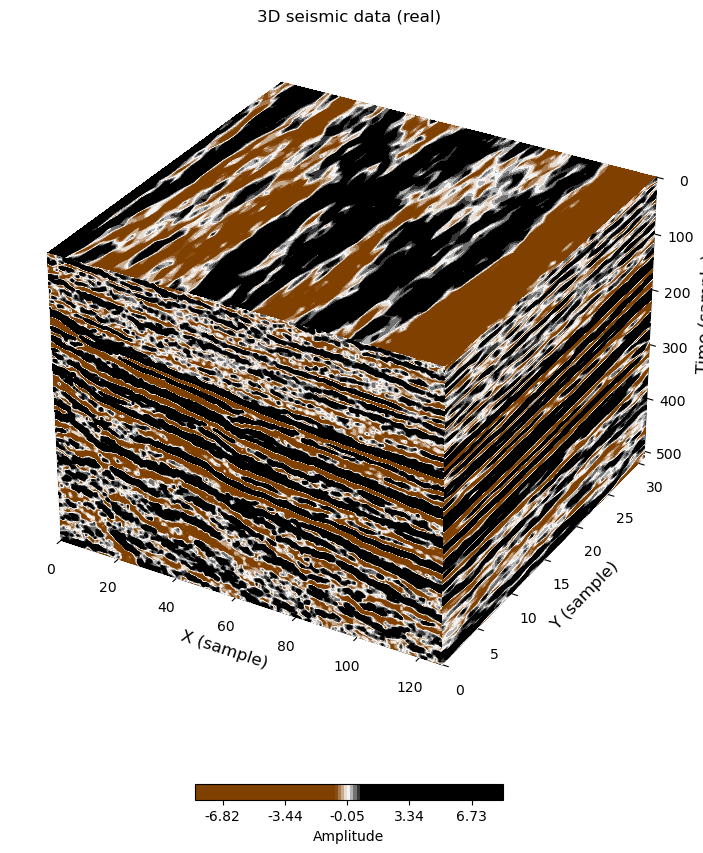

In [8]:
# Prepared On Feb 19, 2025 by Yangkang Chen, UT-Austin
#
# As a reproduced example for three papers
# [1] Chen, Y., Zhang, M., Bai, M., & Chen, W. (2019). Improving the signal‐to‐noise ratio of seismological datasets by unsupervised machine learning. Seismological Research Letters, 90(4), 1552-1564.
# [2] Saad, O. M., & Chen, Y. (2021). A fully unsupervised and highly generalized deep learning approach for random noise suppression. Geophysical Prospecting, 69(4), 709-726.
# [3] Yang, L., Wang, S., Chen, X., Saad, O.M., Chen, W., Oboue, Y.A.S.I. and Chen, Y., 2021. Unsupervised 3-D random noise attenuation using deep skip autoencoder. IEEE Transactions on Geoscience and Remote Sensing, 60, pp.1-16.
#
# NOTE: both examples are unsupervised learning approaches. 
# Please use the latest pyseistr package:
# https://github.com/aaspip/pyseistr
#
# Environment: 
# CPU machine
# conda create -n uml python=3.11.7
# conda activate uml
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.14.0 scikit-learn==1.2.2 seaborn==0.13.2 
# 
# GPU machine
# conda create -n uml python=3.10.14
# conda activate uml
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.11.0 scikit-learn==1.2.2 seaborn==0.13.2 
# conda install -c anaconda cudnn==8.2.1
#
#
#First, Download the data from link below
# https://github.com/aaspip/data/blob/main/drr_real3d.mat
import scipy
data = scipy.io.loadmat('drr_real3d.mat')
dt=data['d1']
dx=data['d2']
dy=data['d3']
real=data['data']

import numpy as np
from pyseistr import genplane3d,plot3d
import matplotlib.pyplot as plt

dz=1;dx=1;dy=1;
[nz,nx,ny]=real.shape;

plot3d(real,vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Time (sample)",fontsize='large', fontweight='normal')
plt.title('3D seismic data (real)')
plt.savefig(fname='real3d.png',format='png',dpi=300)
plt.show()

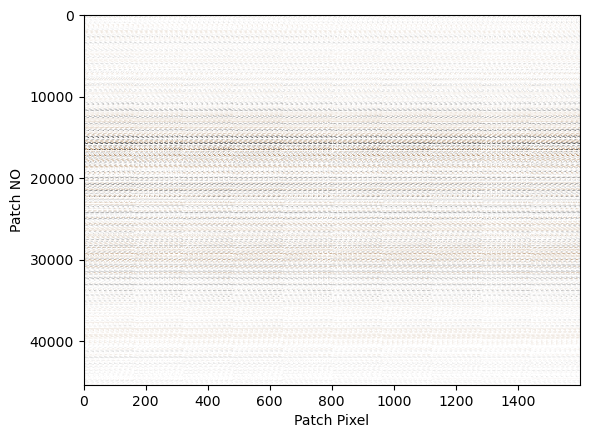

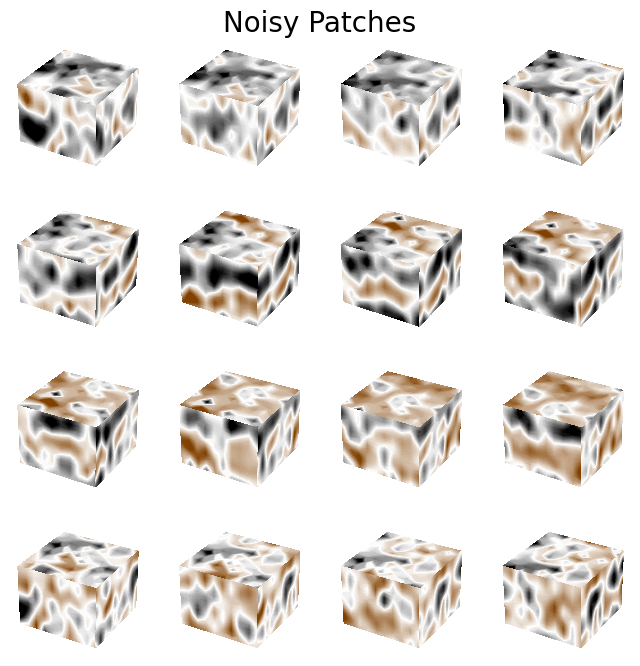

In [11]:
from pyseistr import patch3d,patch3d_inv,snr
Xnoisy=patch3d(real,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);

from pyseistr import cseis
plt.imshow(Xnoisy,aspect='auto',cmap=cseis());plt.ylabel('Patch NO');plt.xlabel('Patch Pixel');plt.show()

# plot noisy patches
plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xnoisy[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Noisy Patches",size=20)
plt.show()


In [12]:
from keras import layers
from keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, LeakyReLU,BatchNormalization
# from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# The following architecture was used in 
# Chen, Y., Zhang, M., Bai, M., & Chen, W. (2019). Improving the signal‐to‐noise ratio of seismological datasets by unsupervised machine learning. Seismological Research Letters, 90(4), 1552-1564.

input = layers.Input(shape=(1600,))                            #or from tensorflow.keras.layers import Input, Dense
x = layers.Dense(128, activation="relu", name="layer1")(input)  
x = layers.Dense(1600, activation="linear", name="layer2")(x)  

# Autoencoder
autoencoder = Model(input,x)
autoencoder.summary()

# Compile
autoencoder.compile(optimizer="adam", loss='mse')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1600)           │       206,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,328 (1.57 MB)

 Trainable params: 411,328 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
import datetime
today=datetime.date.today()
weightname='best_model_%s.weights.h5'%str(today)


checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=20,callbacks=[checkpoint,lr_reducer],validation_split=0.2)


Epoch 1/20
267/284 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8491
Epoch 1: val_loss improved from inf to 0.27989, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8292 - val_loss: 0.2799 - learning_rate: 0.0010
Epoch 2/20
276/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3043
Epoch 2: val_loss improved from 0.27989 to 0.22650, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3038 - val_loss: 0.2265 - learning_rate: 0.0010
Epoch 3/20
270/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2483
Epoch 3: val_loss improved from 0.22650 to 0.20039, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2479 - val_loss: 0.2004 - learning_rate: 0.0010
Epoch 4/20
268/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2211
Epoch 4: val_loss improved from 0.20039 to 0.18195, saving model to best_model_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms

In [14]:
Xout = autoencoder.predict(Xnoisy)

1418/1418 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


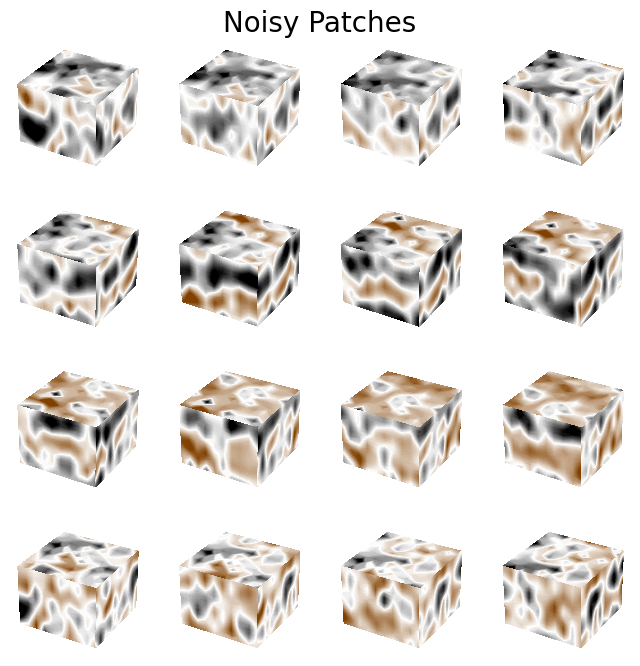

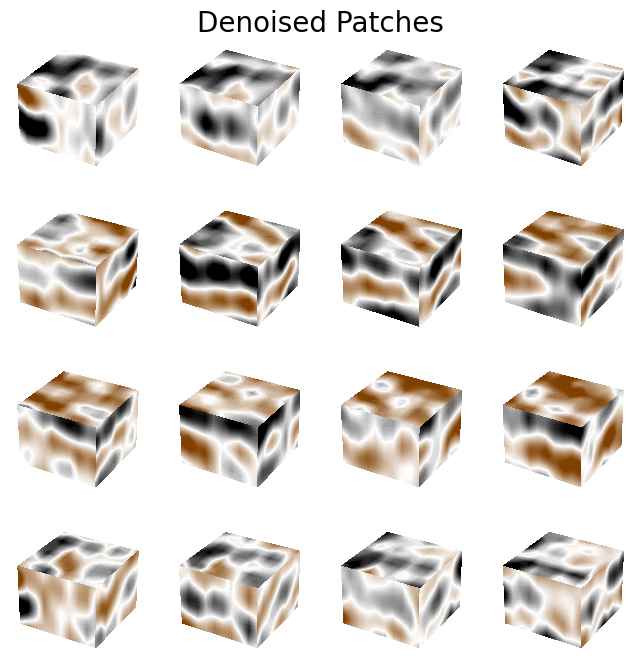

In [15]:
# plt.figure(figsize=(8,8))
# for ii in range(64):
#             ax=plt.subplot(8,8,ii+1)
#             plt.imshow(Xnoisy[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
#             plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
# plt.show()

# plt.figure(figsize=(8,8))
# for ii in range(64):
#             ax=plt.subplot(8,8,ii+1)
#             plt.imshow(Xout[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
#             plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
# plt.show()

plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xnoisy[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Noisy Patches",size=20)
plt.show()

plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xout[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Denoised Patches",size=20)
plt.show()

/Users/chenyk/aaspip.pyseistr/pyseistr/plot.py:160: UserWarning: The following kwargs were not used by contour: 'barlabel'
  _ = ax.contourf(
/Users/chenyk/aaspip.pyseistr/pyseistr/plot.py:165: UserWarning: The following kwargs were not used by contour: 'barlabel'
  _ = ax.contourf(
/Users/chenyk/aaspip.pyseistr/pyseistr/plot.py:170: UserWarning: The following kwargs were not used by contour: 'barlabel'
  C = ax.contourf(


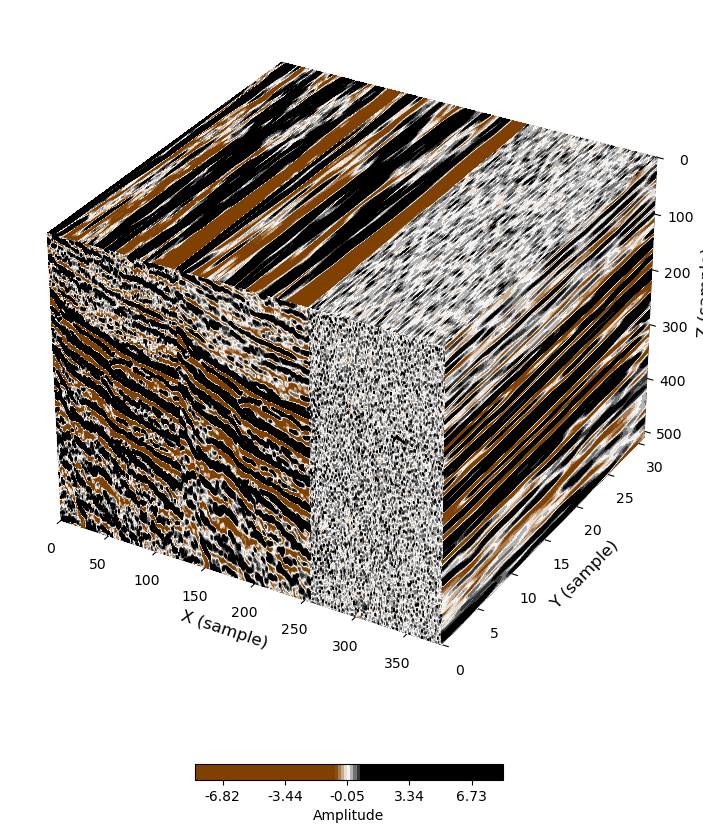

In [17]:
# reconstruct data
denoised=patch3d_inv(Xout,nz,nx,ny,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);

plot3d(np.concatenate([real,denoised,real-denoised],axis=1),vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx*3)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
# plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised,mode=2)))
plt.savefig(fname='real3d-denoised.png',format='png',dpi=300)
plt.show()

In [18]:
## Different implementations

from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, LeakyReLU,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# The following architecture was used in 
# Saad, O. M., & Chen, Y. (2021). A fully unsupervised and highly generalized deep learning approach for random noise suppression. Geophysical Prospecting, 69(4), 709-726.

## In comparison with a simpler and textbook example
# input = layers.Input(shape=(256,))                            
# x = layers.Dense(64, activation="relu", name="layer1")(input)  
# x = layers.Dense(256, activation="linear", name="layer2")(x)  

input = Input(shape=(1600,))

encoded02 = Dense(800,  activation='relu')(input)

encoded01 = Dense(400,  activation='relu')(encoded02)

encoded1 = Dense(128,  activation='relu')(encoded01)
#encoded1 = BatchNormalization()(encoded1)
#encoded1 = Dropout(0.01)(encoded1)

encoded2 = Dense(64,  activation='relu')(encoded1)
#encoded2 = BatchNormalization()(encoded2)
#encoded2 = Dropout(0.01)(encoded2)

encoded3 = Dense(32,  activation='relu' )(encoded2)
#encoded3 = BatchNormalization()(encoded3)
#encoded3 = Dropout(0.01)(encoded3)

encoded4 = Dense(16,  activation='relu' )(encoded3)
#encoded3 = BatchNormalization()(encoded3)
#encoded4 = Dropout(0.01)(encoded4)

encoded5 = Dense(8,  activation='relu' )(encoded4)
#encoded5 = BatchNormalization()(encoded5)
#encoded5 = Dropout(0.01)(encoded5)

encoded6 = Dense(4,  activation='relu' )(encoded5)
#encoded6 = BatchNormalization()(encoded6)
#encoded6 = Dropout(0.01)(encoded6)

# Decoder

decoded1aa = Dense(4,  activation='relu' )(encoded6)
#decoded1aa = BatchNormalization()(decoded1aa)
decoded1aa = concatenate([decoded1aa,encoded6])
#decoded1aa = Dropout(0.01)(decoded1aa)


decoded1a = Dense(8,  activation='relu' )(decoded1aa)
#decoded1a = BatchNormalization()(decoded1a)
decoded1a = concatenate([decoded1a,encoded5])
#decoded1a = Dropout(0.01)(decoded1a)

decoded1 = Dense(16,  activation='relu' )(decoded1a)
#decoded1 = BatchNormalization()(decoded1)
decoded1 = concatenate([decoded1,encoded4])
#decoded1 = Dropout(0.01)(decoded1)

decoded2 = Dense(32,  activation='relu')(decoded1)
#decoded2 = BatchNormalization()(decoded2)
decoded2 = concatenate([decoded2,encoded3])
#decoded2 = Dropout(0.01)(decoded2)

decoded3 = Dense(64,  activation='relu' )(decoded2)
#decoded3 = BatchNormalization()(decoded3)
decoded3 = concatenate([decoded3,encoded2])
#decoded3 = Dropout(0.01)(decoded3)

decoded4 = Dense(128,  activation='relu' )(decoded3)
#decoded4 = BatchNormalization()(decoded4)
decoded4 = concatenate([decoded4,encoded1])
#decoded4 = Dropout(0.01)(decoded4)

decoded401 = Dense(400,  activation='relu' )(decoded4)
decoded401 = concatenate([decoded401,encoded01])

decoded402 = Dense(800,  activation='relu' )(decoded401)
decoded402 = concatenate([decoded402,encoded02])

#decoded = Flatten()(decoded3)
x = Dense(1600, activation='linear')(decoded402)


# Autoencoder
autoencoder = Model(input,x)
autoencoder.summary()

# Compile
autoencoder.compile(optimizer="adam", loss='mse')


import datetime
today=datetime.date.today()
weightname='best_model_PATCHUNET_%s.weights.h5'%str(today)

earlystop  = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=4,callbacks=[earlystop,checkpoint,lr_reducer],validation_split=0.2)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1600)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 800)       │  1,280,800 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 400)       │    320,400 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     51,328 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        528 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8)         │        136 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │         36 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 4)         │         20 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8)         │          0 │ dense_8[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 8)         │         72 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16)        │          0 │ dense_9[0][0],    │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 16)        │        272 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32)        │          0 │ dense_10[0][0],   │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      1,056 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64)        │          0 │ dense_11[0][0],   │
│ (Concatenate)       │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      4,160 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128)       │          0 │ dense_12[0][0],   │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     16,512 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 256)       │          0 │ dense_13[0][0],   │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,990,856 (19.04 MB)

 Trainable params: 4,990,856 (19.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5826
Epoch 1: val_loss improved from inf to 0.14531, saving model to best_model_PATCHUNET_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.5817 - val_loss: 0.1453 - learning_rate: 0.0010
Epoch 2/4
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1656
Epoch 2: val_loss improved from 0.14531 to 0.08953, saving model to best_model_PATCHUNET_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1653 - val_loss: 0.0895 - learning_rate: 0.0010
Epoch 3/4
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1081
Epoch 3: val_loss improved from 0.08953 to 0.06164, saving model to best_model_PATCHUNET_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1080 - val_loss: 0.0616 - learning_rate: 0.0010
Epoch 4/4
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0764
Epoch 4: val_loss improved from 0.06164 to 0.04894, saving model to best_model_PATCHUNET_2025-02-19.wei

1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


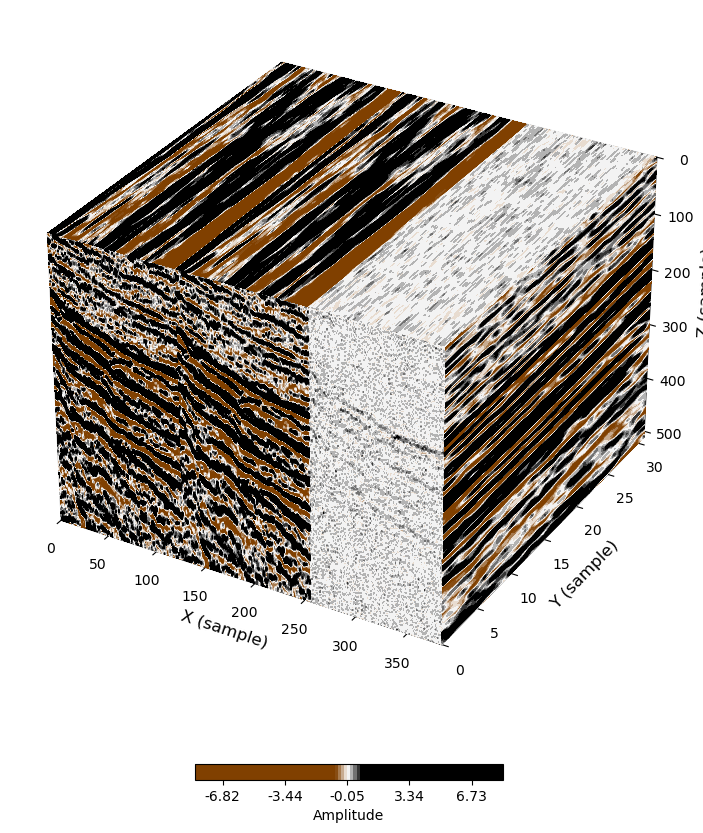

In [19]:
Xout = autoencoder.predict(Xnoisy)

# reconstruct data
denoised2=patch3d_inv(Xout,nz,nx,ny,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);

plot3d(np.concatenate([real,denoised2,real-denoised2],axis=1),vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx*3)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
# plt.title('Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised2,mode=2)))
plt.savefig(fname='real3d-denoised2.png',format='png',dpi=300)
plt.show()


## NOTE:
##
## Why a much more complicated network architecture does not bring as much benefit as we want
##
## Maybe because this problem is not complicated enough that needs a complicated architecture
## e.g., the data structure is not complicated at all (here it is simply linear events)
## So, always be careful about designing the "complicated" network architecture that best suits your data

In [20]:
# For field data, using local similarity (Chen and Fomel, 2015) for evaluate the "signal leakage"
# !pip install pyortho

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/SCons-4.8.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Preparing metadata (setup.py) ... done
  Created wheel for pyortho: filename=pyortho-0.0.5.1-cp312-cp312-macosx_11_0_arm64.whl size=50677 sha256=a08b21651aebe137114a531450cc742a90c3a94e91c15a74075c0f3f4ce1801c
  Stored in directory: /Users/chenyk/Library/Caches/pip/wheels/cb/b0/02/f97b78ce36a56f762cd52c3f744cbc7fa61f8a66dadb8c7566
Successfully built pyortho


In [23]:
from pyortho import localsimic

In [25]:
signal=denoised;
noise=real-denoised;
simi1=localsimic(signal,noise,[5,5,5],niter=20);

512 128 32 5 5 5 20 0.0 1


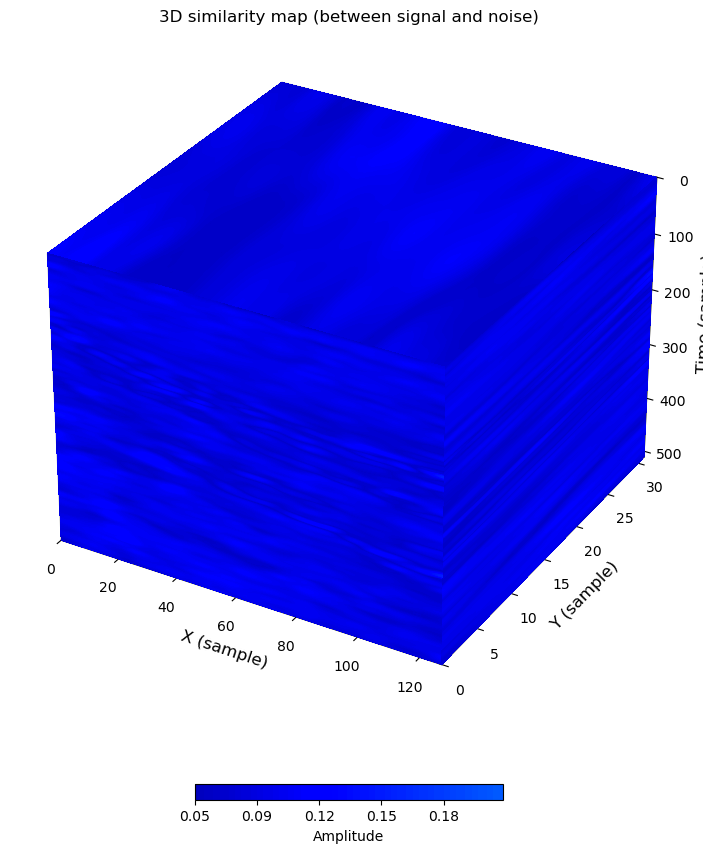

In [31]:
plot3d(simi1,vmin=0,vmax=1,cmap=plt.cm.jet,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Time (sample)",fontsize='large', fontweight='normal')
plt.title('3D similarity map (between signal and noise)')
plt.savefig(fname='real3d-simi.png',format='png',dpi=300)
plt.show()
## This one is pretty successful (negligible signal leakage)

In [33]:
signal2=denoised2;
noise2=real-denoised2;
simi12=localsimic(signal2,noise2,[5,5,5],niter=20);

512 128 32 5 5 5 20 0.0 1


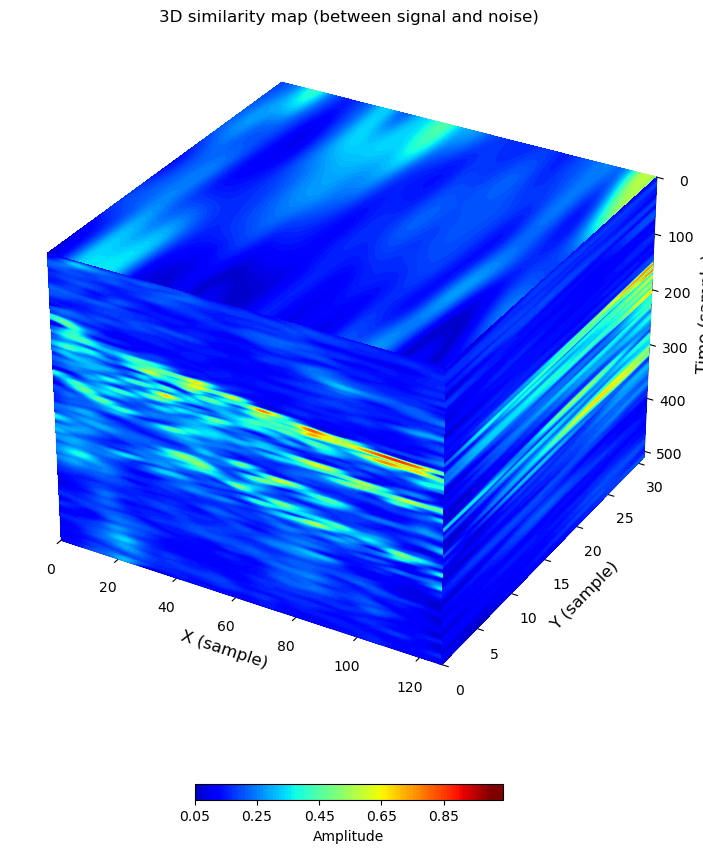

In [34]:
plot3d(simi12,vmin=0,vmax=1,cmap=plt.cm.jet,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Time (sample)",fontsize='large', fontweight='normal')
plt.title('3D similarity map (between signal and noise)')
plt.savefig(fname='real3d-simi2.png',format='png',dpi=300)
plt.show()

Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0109
Epoch 1: val_loss improved from 0.00551 to 0.00540, saving model to best_model_PATCHUNET_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0109 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 2/10
282/284 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0114
Epoch 2: val_loss improved from 0.00540 to 0.00466, saving model to best_model_PATCHUNET_2025-02-19.weights.h5
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0114 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 3/10
283/284 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0084
Epoch 3: val_loss did not improve from 0.00466
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0084 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 4/10
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0104
Epoch 4: val_loss did not improve from 0.00466
284/284 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0104 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 5/10
2

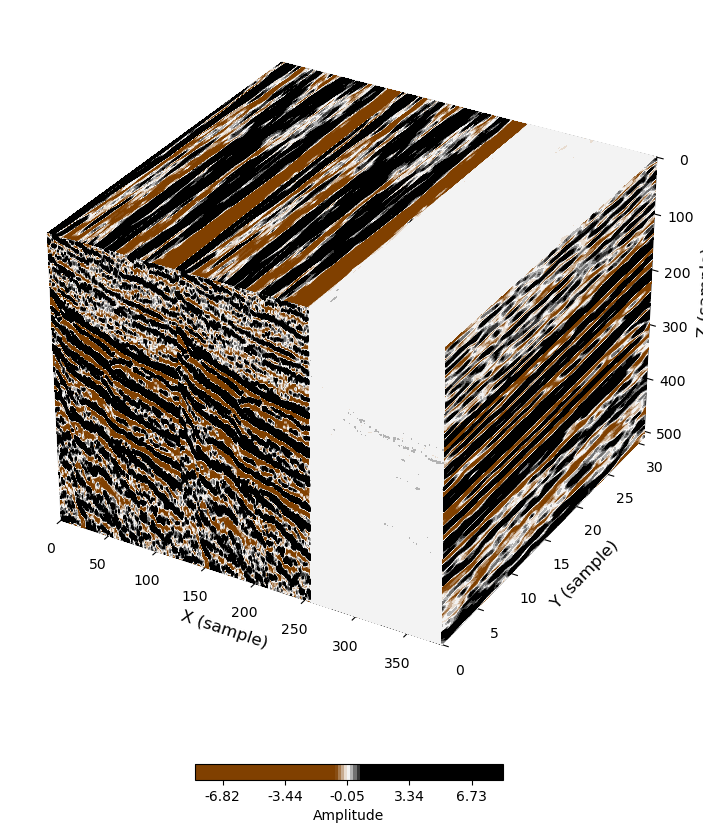

512 128 32 5 5 5 20 0.0 1


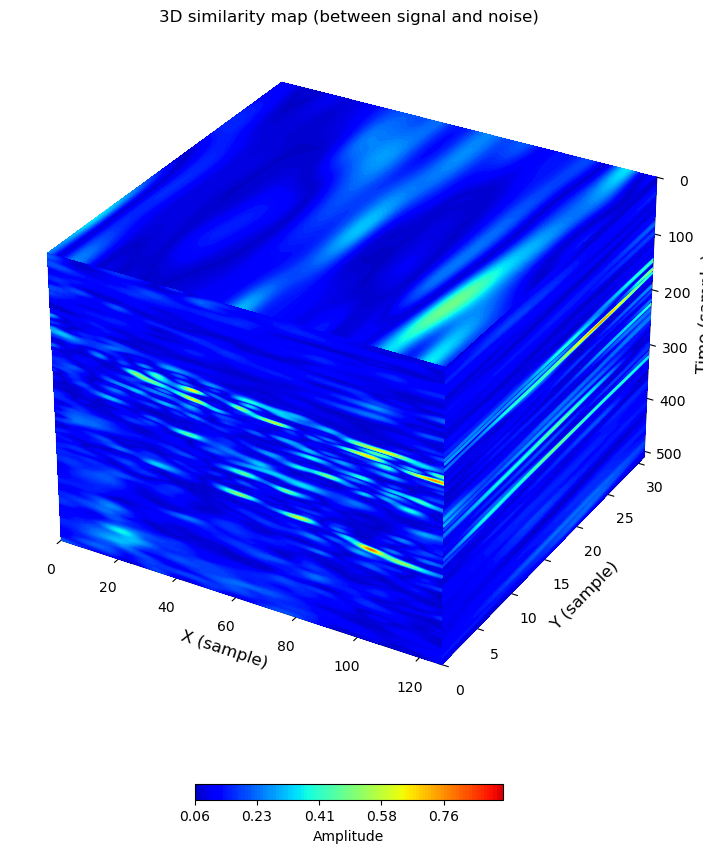

In [36]:
#To make the result of PatchUnet better
# Increase the number of epochs? Is it enough? 

autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=10,callbacks=[earlystop,checkpoint,lr_reducer],validation_split=0.2)

Xout = autoencoder.predict(Xnoisy)

# reconstruct data
denoised3=patch3d_inv(Xout,nz,nx,ny,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);

plot3d(np.concatenate([real,denoised3,real-denoised3],axis=1),vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx*3)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
plt.savefig(fname='real3d-denoised3.png',format='png',dpi=300)
plt.show()

# Local Similarity (Chen and Fomel, 2015)
signal3=denoised3;
noise3=real-denoised3;
simi13=localsimic(signal3,noise3,[5,5,5],niter=20);

plot3d(simi13,vmin=0,vmax=1,cmap=plt.cm.jet,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Time (sample)",fontsize='large', fontweight='normal')
plt.title('3D similarity map (between signal and noise)')
plt.savefig(fname='real3d-simi3.png',format='png',dpi=300)
plt.show()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 6400)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 800)       │  5,120,800 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 400)       │    320,400 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 128)       │     51,328 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │      8,256 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 32)        │      2,080 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 16)        │        528 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 8)         │        136 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 4)         │         36 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 4)         │         20 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 8)         │          0 │ dense_25[0][0],   │
│ (Concatenate)       │                   │            │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 8)         │         72 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 16)        │          0 │ dense_26[0][0],   │
│ (Concatenate)       │                   │            │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 16)        │        272 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 32)        │          0 │ dense_27[0][0],   │
│ (Concatenate)       │                   │            │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 32)        │      1,056 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 64)        │          0 │ dense_28[0][0],   │
│ (Concatenate)       │                   │            │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 64)        │      4,160 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 128)       │          0 │ dense_29[0][0],   │
│ (Concatenate)       │                   │            │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │     16,512 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 256)       │          0 │ dense_30[0][0],   │
│ (Concatenate)       │                   │            │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,515,656 (63.00 MB)

 Trainable params: 16,515,656 (63.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.3486
Epoch 1: val_loss improved from inf to 0.41627, saving model to best_model_PATCHUNET_2025-02-19.weights.h5
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.3358 - val_loss: 0.4163 - learning_rate: 0.0010
Epoch 2/8
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5268
Epoch 2: val_loss improved from 0.41627 to 0.34978, saving model to best_model_PATCHUNET_2025-02-19.weights.h5
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.5256 - val_loss: 0.3498 - learning_rate: 0.0010
Epoch 3/8
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.4150
Epoch 3: val_loss improved from 0.34978 to 0.31378, saving model to best_model_PATCHUNET_2025-02-19.weights.h5
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.4147 - val_loss: 0.3138 - learning_rate: 0.0010
Epoch 4/8
65/66 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3762
Epoch 4: val_loss improved from 0.31378 to 0.28450, saving model to best_model_PATCHUNET_2025-02-19.weights.h5
66/66 

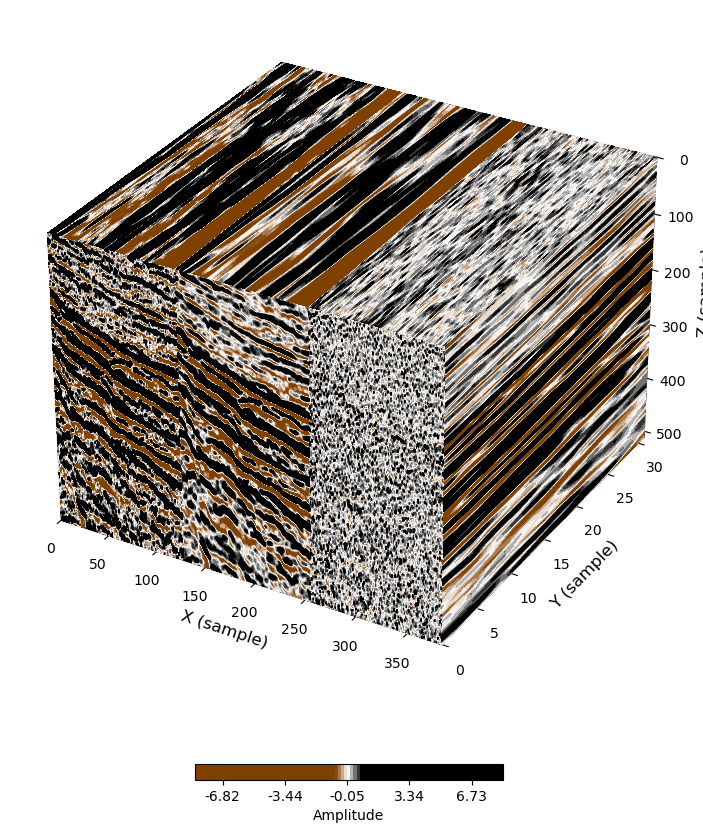

512 128 32 5 5 5 20 0.0 1


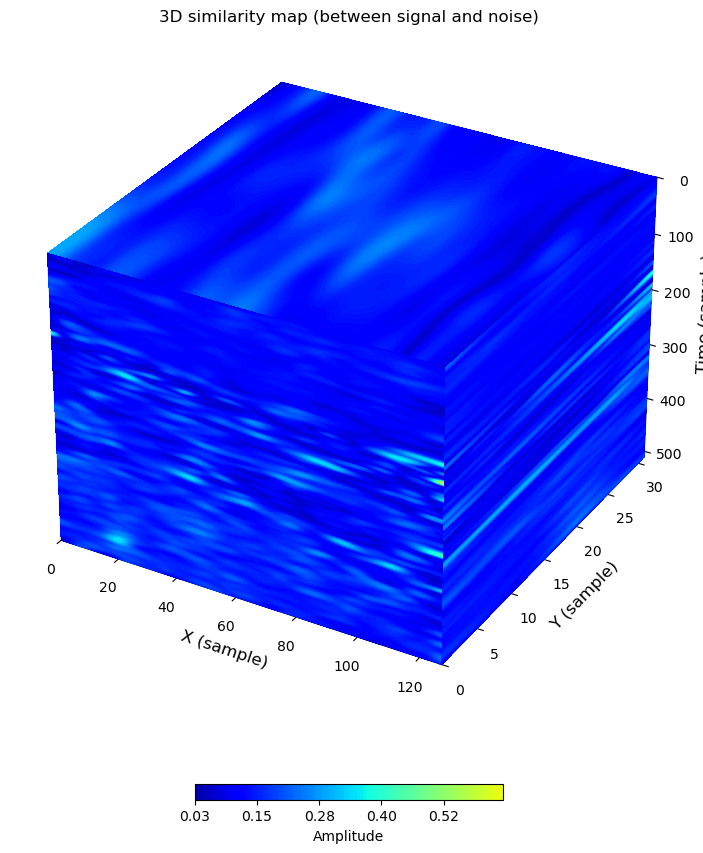

In [39]:
## This way works better
# Think about Why we need to change the patch size ?

Xnoisy=patch3d(real,l1=32,l2=20,l3=10,s1=16,s2=4,s3=2);

input = Input(shape=(Xnoisy.shape[1],))

encoded02 = Dense(800,  activation='relu')(input)

encoded01 = Dense(400,  activation='relu')(encoded02)

encoded1 = Dense(128,  activation='relu')(encoded01)
#encoded1 = BatchNormalization()(encoded1)
#encoded1 = Dropout(0.01)(encoded1)

encoded2 = Dense(64,  activation='relu')(encoded1)
#encoded2 = BatchNormalization()(encoded2)
#encoded2 = Dropout(0.01)(encoded2)

encoded3 = Dense(32,  activation='relu' )(encoded2)
#encoded3 = BatchNormalization()(encoded3)
#encoded3 = Dropout(0.01)(encoded3)

encoded4 = Dense(16,  activation='relu' )(encoded3)
#encoded3 = BatchNormalization()(encoded3)
#encoded4 = Dropout(0.01)(encoded4)

encoded5 = Dense(8,  activation='relu' )(encoded4)
#encoded5 = BatchNormalization()(encoded5)
#encoded5 = Dropout(0.01)(encoded5)

encoded6 = Dense(4,  activation='relu' )(encoded5)
#encoded6 = BatchNormalization()(encoded6)
#encoded6 = Dropout(0.01)(encoded6)

# Decoder

decoded1aa = Dense(4,  activation='relu' )(encoded6)
#decoded1aa = BatchNormalization()(decoded1aa)
decoded1aa = concatenate([decoded1aa,encoded6])
#decoded1aa = Dropout(0.01)(decoded1aa)


decoded1a = Dense(8,  activation='relu' )(decoded1aa)
#decoded1a = BatchNormalization()(decoded1a)
decoded1a = concatenate([decoded1a,encoded5])
#decoded1a = Dropout(0.01)(decoded1a)

decoded1 = Dense(16,  activation='relu' )(decoded1a)
#decoded1 = BatchNormalization()(decoded1)
decoded1 = concatenate([decoded1,encoded4])
#decoded1 = Dropout(0.01)(decoded1)

decoded2 = Dense(32,  activation='relu')(decoded1)
#decoded2 = BatchNormalization()(decoded2)
decoded2 = concatenate([decoded2,encoded3])
#decoded2 = Dropout(0.01)(decoded2)

decoded3 = Dense(64,  activation='relu' )(decoded2)
#decoded3 = BatchNormalization()(decoded3)
decoded3 = concatenate([decoded3,encoded2])
#decoded3 = Dropout(0.01)(decoded3)

decoded4 = Dense(128,  activation='relu' )(decoded3)
#decoded4 = BatchNormalization()(decoded4)
decoded4 = concatenate([decoded4,encoded1])
#decoded4 = Dropout(0.01)(decoded4)

decoded401 = Dense(400,  activation='relu' )(decoded4)
decoded401 = concatenate([decoded401,encoded01])

decoded402 = Dense(800,  activation='relu' )(decoded401)
decoded402 = concatenate([decoded402,encoded02])

#decoded = Flatten()(decoded3)
x = Dense(Xnoisy.shape[1], activation='linear')(decoded402)


# Autoencoder
autoencoder = Model(input,x)
autoencoder.summary()

# Compile
autoencoder.compile(optimizer="adam", loss='mse')


import datetime
today=datetime.date.today()
weightname='best_model_PATCHUNET_%s.weights.h5'%str(today)

earlystop  = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=8,callbacks=[earlystop,checkpoint,lr_reducer],validation_split=0.2)

Xout = autoencoder.predict(Xnoisy)

# reconstruct data
denoised3=patch3d_inv(Xout,nz,nx,ny,l1=32,l2=20,l3=10,s1=16,s2=4,s3=2);

plot3d(np.concatenate([real,denoised3,real-denoised3],axis=1),vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx*3)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
plt.savefig(fname='real3d-denoised3.png',format='png',dpi=300)
plt.show()

# Local Similarity (Chen and Fomel, 2015)
signal3=denoised3;
noise3=real-denoised3;
simi13=localsimic(signal3,noise3,[5,5,5],niter=20);

plot3d(simi13,vmin=0,vmax=1,cmap=plt.cm.jet,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Time (sample)",fontsize='large', fontweight='normal')
plt.title('3D similarity map (between signal and noise)')
plt.savefig(fname='real3d-simi3.png',format='png',dpi=300)
plt.show()

